# JS_EDA__X_Y_LOCATION

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

import missingno as msno

import warnings
warnings.filterwarnings("ignore") 

from datetime import datetime
from IPython.display import display, Markdown

In [2]:
#Map locations and see what place value is important
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

In [3]:
for library in [pd,sns,msno]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

'pandas'  version is  1.0.5
'seaborn'  version is  0.10.1
'missingno'  version is  0.4.2


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions

In [5]:
# make a dictionary of the LOCATIONs that do have X, Y
def make_location_dict(df,location,xcol,ycol):
    location_dict = dict()
    xy_dict = dict() # empty template
    xy_dict['X'] = 0
    xy_dict['Y'] = 0

    for idx,row in df[df['X'].notnull()].iterrows():
        this_loc = row[location]

        if this_loc in location_dict.keys():
            if location_dict[this_loc]['X'] != row[xcol]:
                print(f"Same loc, new X: {this_loc}, {row[xcol]}")
            if location_dict[this_loc]['Y'] != row[ycol]:
                print(f"Same loc, new Y: {this_loc}, {row[ycol]}")                                
        else:
            location_dict[this_loc] = xy_dict.copy()
            location_dict[this_loc]['X'] = row[xcol]
            location_dict[this_loc]['Y'] = row[ycol]  
            
    return location_dict

In [6]:
def find_X(location_dict,location_string,old_x, debug=False):
    # only need to do this if the old_x is NaN
    if (math.isnan(old_x)) and (location_string in location_dict.keys()):
        newX = location_dict[location_string]['X']
        if (debug):
            print(f"Filling in X for {location_string}")
    else:
        newX = old_x
    #print(f"{location_string}  {newX},{newY}")
    return newX

def find_Y(location_dict,location_string,old_y, debug=False):
    if (math.isnan(old_y)) and (location_string in location_dict.keys()):
        newY = location_dict[location_string]['Y']
        if (debug):
            print(f"Filling in Y for {location_string}")
    else:
        newY = old_y
    #print(f"{location_string}  {newX},{newY}")
    return newY

## Load files

In [7]:
df = pd.read_csv('../data/collisions_orig.csv', parse_dates=["INCDTTM"])

In [8]:
# intersections.csv
# http://data-seattlecitygis.opendata.arcgis.com/datasets/0ea49a3a3ff54ae6af2aaae47dd680fe_5.csv?outSR={%22latestWkid%22:2926,%22wkid%22:2926}

dfi = pd.read_csv('../data/intersections.csv')

In [9]:
dfi.head()

,X,Y,OBJECTID,INTR_ID,GIS_XCOORD,GIS_YCOORD,COMPKEY,COMPTYPE,UNITID,SUBAREA,UNITDESC,ARTERIALCLASSCD,SIGNAL_MAINT_DIST,SIGNAL_TYPE,SHAPE_LNG,SHAPE_LAT
0,1.270709e+06,194387.955195,1,18213,1.270709e+06,194387.95532,340313,13,78852,GRDWM,4TH AVE S AND S HENDERSON N ST,0.0,,NONE,-122.329732,47.523051
1,1.282582e+06,234414.695012,2,10302,1.282582e+06,234414.69508,157936,13,32854,E,WOODROW PL E AND E GARFIELD ST,0.0,,NONE,-122.284745,47.633387
2,1.261648e+06,256226.497210,3,4716,1.261648e+06,256226.49721,37264,13,231740,BLRD,12TH AVE NW AND NW 87TH ST,0.0,,NONE,-122.371401,47.692058
3,1.281381e+06,228692.212062,4,11483,1.281381e+06,228692.21187,30231,13,42513,CNTRL,34TH AVE AND E HOWELL ST,3.0,,NONE,-122.289176,47.617639
4,1.274017e+06,249395.188339,5,6406,1.274017e+06,249395.18840,25752,13,14252,NE,NE 63RD ST AND NE RAVENNA EB BV,1.0,,NONE,-122.320648,47.674000


In [10]:
#features_1 = ['X','Y','LOCATION','INCDATE']

In [11]:
# use the other rows of our data to make a dictionary converting LOCATION text to X, Y
self_loc_dict = make_location_dict(df,'LOCATION','X','Y') 
# investigate this one -- they are very close together on the same roadway; either is fine
# ...but there are not other lines with missing data that would used this anyway

Same loc, new X: 2ND AVE S AND S SPOKANE NR ST, -122.331939324729
Same loc, new Y: 2ND AVE S AND S SPOKANE NR ST, 47.5717239239888


In [12]:
# use the intersection data to make a dictionary converting LOCATION to X, Y
intersection_dict = make_location_dict(dfi,'UNITDESC','SHAPE_LNG','SHAPE_LAT')

In [13]:
# check number of missing X before any updates
starting_nulls = df['X'].isnull().sum()
starting_nulls

7461

### Consider dictionaries...are they both valuable?

In [14]:
only_in_self = [x for x in self_loc_dict.keys() if x not in intersection_dict.keys()]
only_in_inter = [x for x in intersection_dict.keys() if x not in self_loc_dict.keys()]
print(f"Only in self: {len(only_in_self)}, only in intersections {len(only_in_inter)}")
print(f"Overlap: {len(intersection_dict.keys())-len(only_in_inter)}")

# Note: most of the items that are only in self include "BETWEEN"

Only in self: 17157, only in intersections 7662
Overlap: 7779


### Update X, Y based on other examples in the collisions.csv

In [15]:
df['X'] = df.apply(lambda x: find_X(self_loc_dict,x['LOCATION'],x['X'],debug=True), axis=1)
df['Y'] = df.apply(lambda x: find_Y(self_loc_dict,x['LOCATION'],x['Y']), axis=1)
# Only solves 4

Filling in X for 6TH AVE N AND MERCER ST
Filling in X for 5TH AVE AND MARION ST
Filling in X for 5TH AVE AND MARION ST
Filling in X for 6TH AVE N AND MERCER ST


In [16]:
# check number of missing X after intersection update
df['X'].isnull().sum()

7457

### Update X, Y based on intersections.csv

In [17]:
# update based on intersection file
df['X'] = df.apply(lambda x: find_X(intersection_dict,x['LOCATION'],x['X'], debug=True), axis=1)
df['Y'] = df.apply(lambda x: find_Y(intersection_dict,x['LOCATION'],x['Y']), axis=1)

Filling in X for 4TH AVE S AND XW WELLER
Filling in X for 35TH AVE SW AND FAUNTLEROY N WAY SW
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for 2ND AVE N AND THOMAS ST
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for ALASKAN WAY S AND S ROYAL BROUGHAM WAY
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for CORGIAT DR S AND S CORGIAT DR
Filling in X for E HIGHLAND DR AND DEAD END 2
Filling in X for ALASKAN WAY S AND S DEARBORN ST
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for CORGIAT DR S AND S CORGIAT DR
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for STONE AVE N AND N 135TH ST
Filling in X for GALER ST AND TAYLOR UPPER AVE N
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for GOLDEN GARDENS DR NW AND SEAVIEW PL NW
Filling in X for E JAMES WAY AND XW 10TH AVE
Filling in X for ALASKAN WAY S AND S KING ST
Filling in X for ALASKAN WAY W AND W GALER ST
Filling in X for 2ND AVE N AND THOMAS ST
Filling in X for ALASKAN

Filling in X for I5 SB AND 145TH ST ON RP
Filling in X for I5 SB AND 145TH ST ON RP
Filling in X for SW KLICKITAT NR WAY AND SW SPOKANE NR ST
Filling in X for DUWAMISH RIVER TRL AND WEST MARGINAL WAY SW
Filling in X for ALASKAN WAY S AND S DEARBORN ST
Filling in X for DUWAMISH RIVER TRL AND WEST MARGINAL WAY SW
Filling in X for 42ND AVE S AND DEAD END 1
Filling in X for SYLVAN WAY SW AND SW SYLVAN HEIGHTS DR
Filling in X for E YESLER WAY AND DEAD END 1
Filling in X for ALASKAN WAY S AND S DEARBORN ST
Filling in X for 4TH AVE S AND XW WELLER
Filling in X for HOLDEN ST ON RP AND SR509 NB


In [18]:
# check number of missing X after intersection update
current_nulls = df['X'].isnull().sum()
print(f"Starting nulls {starting_nulls} --> current nulls {current_nulls} meaning {starting_nulls-current_nulls} resolved")

Starting nulls 7461 --> current nulls 7269 meaning 192 resolved


## Plot the X, Y that we have

In [19]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [20]:
df_good = df.loc[df['X'].notnull(),['X','Y','FATALITIES']]
df_good.shape

(213167, 3)

In [21]:
lon_list = list(df_good['X'])
type(lon_list)

list

In [22]:
lat_list = list(df_good['Y'])

In [23]:
color_code = list(df_good['FATALITIES'])

In [25]:
sum(color_code) # confirm not all 0

360

In [26]:
def draw_map(lon,lat,color):
# setting up the zoom -- here's the whole world
    m_llcrnrlon = -180
    m_llcrnrlat = -90
    m_urcrnrlon = 180
    m_urcrnrlat = 90   
    
    # try calculating zoom
    if (1):
        border = .005 # 0.01 looks good
        m_llcrnrlat = min(lat_list) - border
        m_urcrnrlat = max(lat_list) + border
        m_llcrnrlon = min(lon_list) - border
        m_urcrnrlon = max(lon_list) + border
        
    # print(f"{m_llcrnrlat} {m_llcrnrlon} {m_urcrnrlon} {m_urcrnrlat}")    # for debug
        
        
    # started with 'cyl'
    # try 'mill' for miller and add resolution
    
    
    # resolution can be ``c`` (crude), ``l`` (low), ``i`` (intermediate), 
    #   ``h``(high), ``f`` (full) or None.
    set_res = 'f'
    
    
    _ = map_plotter = Basemap(projection='cyl',\
                                 llcrnrlon = m_llcrnrlon,\
                                 llcrnrlat = m_llcrnrlat,\
                                 urcrnrlon = m_urcrnrlon,\
                                 urcrnrlat = m_urcrnrlat,\
                                 resolution=set_res) ;
    
    plt.figure(figsize=(20, 20));
    #map_plotter.shadedrelief()   # appears to be insufficient detail for city level
    #map_plotter.bluemarble()     # appears to be insufficient detail for city level
    
    
    
    # initial approach - plot everything with red x
    map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=10);
    
    for idx in range(0,len(color_code)):
        color = ['blue' if color_code[idx] == 0 else 'red']
        _ = map_plotter.scatter(lon_list[idx],lat_list[idx],latlon=True, c=color, marker = 'x',s=10);
    
#     for c in range(0,2):
#         mini_df = df_good[df_good[cluster_column]==c]
#         lat_list = mini_df['latitude']
#         lon_list = mini_df['longitude']
#         if (c == -1):  
#             map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=spot_size)
#             D_label_color["Isolate"] = 'red'
#         else:
#             map_plotter.scatter(lon_list,lat_list,latlon=True, c=color_order[c],s=spot_size)
#             str_cluster = "Cluster " + str(c)
#             D_label_color[str_cluster]=color_order[c]

    ax = plt.gca()
    
    title = "Collision X,Y"

    plt.title(title);

In [ ]:
def draw_map(lon,lat,color):
# setting up the zoom -- here's the whole world
    m_llcrnrlon = -180
    m_llcrnrlat = -90
    m_urcrnrlon = 180
    m_urcrnrlat = 90   
    
    # try calculating zoom
    if (1):
        border = .005 # 0.01 looks good
        m_llcrnrlat = min(lat_list) - border
        m_urcrnrlat = max(lat_list) + border
        m_llcrnrlon = min(lon_list) - border
        m_urcrnrlon = max(lon_list) + border
        
    # print(f"{m_llcrnrlat} {m_llcrnrlon} {m_urcrnrlon} {m_urcrnrlat}")    # for debug
        
        
    # started with 'cyl'
    # try 'mill' for miller and add resolution
    
    
    # resolution can be ``c`` (crude), ``l`` (low), ``i`` (intermediate), 
    #   ``h``(high), ``f`` (full) or None.
    set_res = 'f'
    
    
    _ = map_plotter = Basemap(projection='cyl',\
                                 llcrnrlon = m_llcrnrlon,\
                                 llcrnrlat = m_llcrnrlat,\
                                 urcrnrlon = m_urcrnrlon,\
                                 urcrnrlat = m_urcrnrlat,\
                                 resolution=set_res) ;
    
    plt.figure(figsize=(20, 20));
    #map_plotter.shadedrelief()   # appears to be insufficient detail for city level
    #map_plotter.bluemarble()     # appears to be insufficient detail for city level
    
    
    
    # initial approach - plot everything with red x
    map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=10);
    
    for idx in range(0,len(color_code)):
        color = ['blue' if color_code[idx] == 0 else 'red']
        _ = map_plotter.scatter(lon_list[idx],lat_list[idx],latlon=True, c=color, marker = 'x',s=10);
    
#     for c in range(0,2):
#         mini_df = df_good[df_good[cluster_column]==c]
#         lat_list = mini_df['latitude']
#         lon_list = mini_df['longitude']
#         if (c == -1):  
#             map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=spot_size)
#             D_label_color["Isolate"] = 'red'
#         else:
#             map_plotter.scatter(lon_list,lat_list,latlon=True, c=color_order[c],s=spot_size)
#             str_cluster = "Cluster " + str(c)
#             D_label_color[str_cluster]=color_order[c]

    ax = plt.gca()
    
    title = "Collision X,Y"

    plt.title(title);

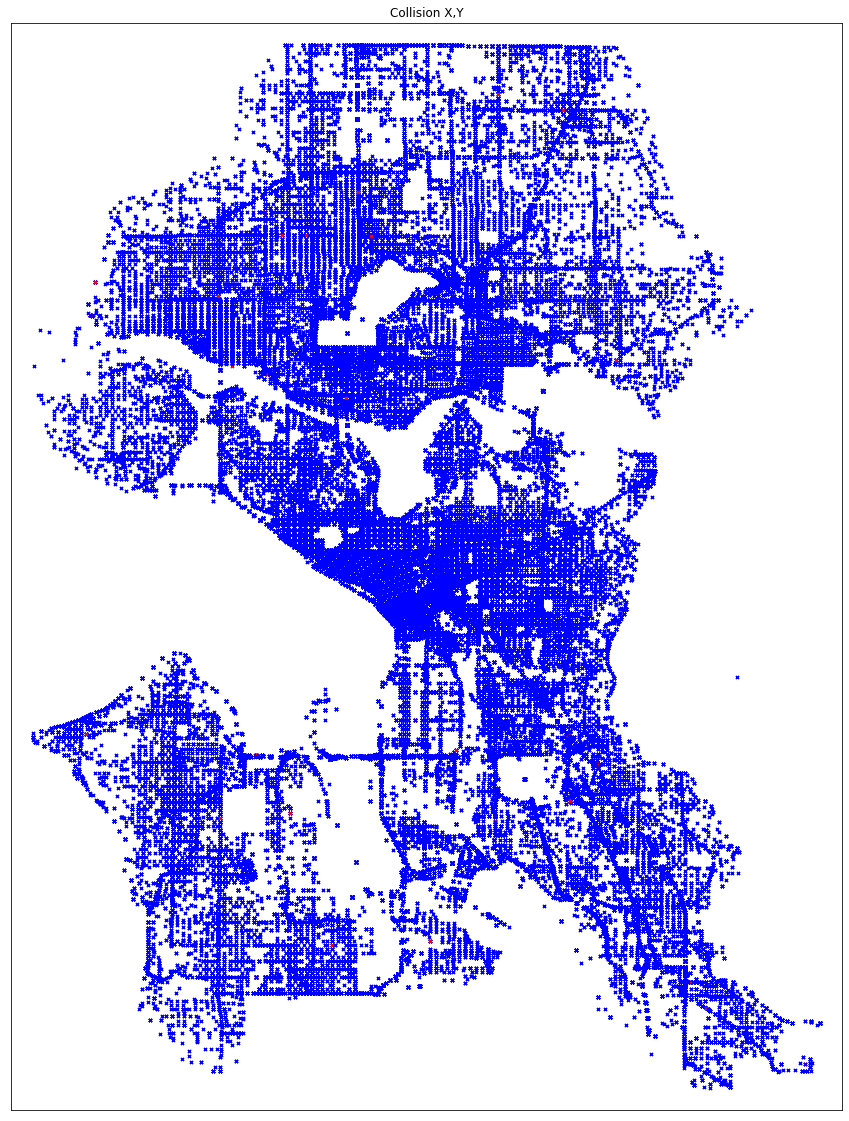

In [27]:
draw_map(lon_list,lat_list,color_code)

## Considering detail level we need for X, Y

In [28]:
def convert_degrees_to_feet(n_deg):
    return (n_deg * 10000 * 3280.4 / 90)

In [29]:
convert_degrees_to_feet(1)  # 1 degree is 364 feet

364488.8888888889

In [30]:
convert_degrees_to_feet(-104.673) # DIA example from https://sciencing.com/convert-latitude-longtitude-feet-2724.html

-38152145.46666667

In [31]:
convert_degrees_to_feet(.01)  # .01 degree is 3644 feet

3644.8888888888887

In [32]:
convert_degrees_to_feet(.00001)  # .00001 degree is 3.644 feet -- this is more than enough precision!

3.644888888888889

In [33]:
# Round the X,Y to 5 decimal places 
np.round(3.644888888888889,5)

3.64489

In [34]:
df['X'] = df['X'].apply(lambda x: np.round(x,5))

In [35]:
df['X'].head()

0   -122.34047
1   -122.25179
2   -122.32853
3   -122.32038
4   -122.36618
Name: X, dtype: float64

In [36]:
df['Y'] = df['Y'].apply(lambda x: np.round(x,5))

In [37]:
df.groupby(['LOCATION','X','Y'])[['LOCATION','X','Y']].count()

,,,LOCATION,X,Y
LOCATION,X,Y,,,
10TH AVE AND E ALDER ST,-122.31941,47.60436,1,1,1
10TH AVE AND E JEFFERSON ST,-122.31942,47.60621,11,11,11
10TH AVE AND E MADISON ST,-122.31935,47.61176,10,10,10
10TH AVE AND E PIKE ST,-122.31945,47.61409,25,25,25
10TH AVE AND E PINE ST,-122.31947,47.61525,23,23,23
...,...,...,...,...,...
YESLER WAY BETWEEN TERRACE ST AND 6TH AVE,-122.32769,47.60171,26,26,26
YESLER WAY BETWEEN WESTERN AVE AND POST AVE,-122.33522,47.60172,4,4,4
YORK RD S BETWEEN 36TH AVE S AND 37TH AVE S,-122.28685,47.57236,4,4,4


# What do these mean in terms of distance?

10TH AVE AND E PIKE ST	-122.31945	47.61409	25	25	25     


10TH AVE AND E PINE ST	-122.31947	47.61525	23	23	23

In [38]:
convert_degrees_to_feet(47.61525 - 47.61409) # 422 feet

422.8071111132336

In [39]:
convert_degrees_to_feet(-122.31945 - -122.31947)

7.289777774911954

In [40]:
# Look for all entries in original data that include 10TH AVE AND E PIKE ST
df_10pike = df[df['LOCATION'] == '10TH AVE AND E PIKE ST'].copy()

In [41]:
df_10pike[['X','Y','LOCATION','ADDRTYPE','INCDATE','JUNCTIONTYPE']].count()

X               25
Y               25
LOCATION        25
ADDRTYPE        25
INCDATE         25
JUNCTIONTYPE    25
dtype: int64

In [42]:
# Spokane street oddity
convert_degrees_to_feet(-122.33094 - -122.33194) 
# 364 foot -- looked at Google Earth -- they are near each other on same roadway; nearest intersection is correct
#    no need to adjust since there are no other uses of this text LOCATION string

364.4888888906293